K-Means

In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py

In [2]:
sql = '''
SELECT *  FROM `eth-tokens.alldata.clean_with_balances_tokens_500k`
'''

df = client.query(sql).to_dataframe()

In [3]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [4]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [5]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [6]:
#get centroids
c = cl.cluster_centers_
#transform back to real numbers
medoids = scale.inverse_transform(pca.inverse_transform(c))
pd.DataFrame(medoids, columns = data.columns)

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_outgoing_txns,monthly_incoming_txns,monthly_eth_sent,monthly_usd_sent,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,num_tokens_used,eth_balance
0,6.412140e+01,6.011939e+01,5.494804e+02,17.165160,2.063883e+05,6.954288e+03,6.290775e+02,51.729076,2.374567e+05,1.707571e+04,...,4.417680,5.100845,3.966036e+01,1.619654e+04,4.975568e+01,2.024020e+04,2.212611,15.384842,8.705851,149.843779
1,8.305309e+06,4.804300e+04,7.338706e+06,1.177553,2.695018e+09,4.498102e+02,6.220197e+05,57.849432,1.715667e+07,3.704765e+04,...,295251.386111,1226.438258,2.088490e+05,7.898487e+07,1.569260e+04,5.119925e+05,11.200000,393128.200000,160.800000,200154.604876
2,1.048904e+06,2.077977e+06,6.185062e+07,63.960316,1.450965e+10,2.009225e+04,3.800469e+07,35.786708,1.200862e+10,1.141519e+04,...,52365.659722,119840.373611,2.440927e+06,8.934627e+08,1.871904e+06,8.494092e+08,0.333333,19268.666667,340.000000,130559.467197
3,7.753691e+04,5.249275e+04,2.746427e+06,13113.424329,6.788972e+08,2.725752e+06,1.788316e+06,41936.884877,4.656446e+08,1.448111e+07,...,5274.210677,4124.635707,1.282601e+05,3.964942e+07,1.078011e+05,3.748781e+07,1045.554455,3535.336634,61.267327,189834.382981


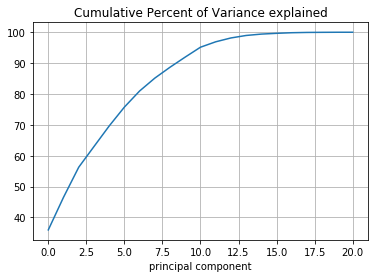

In [7]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

In [8]:
#elbow method


Text(0.5,1,'Calinski Harabaz Scores')

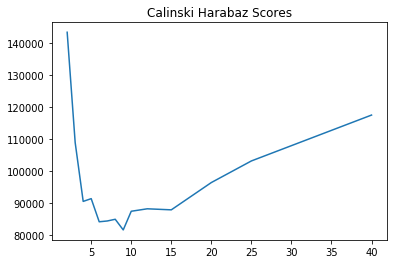

In [9]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [2, 3,4,5,6,7,8,9,10,12,15,20,25, 40]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

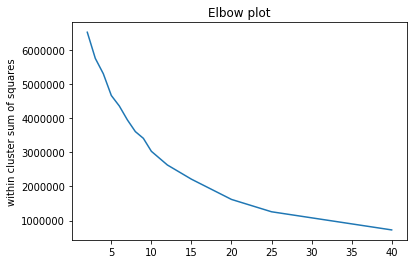

In [10]:
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [14]:
#optmal number of clusters is around 15
cl = KMeans(15)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
#outlier removal


def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [16]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

Text(0.5,1,'Calinski Harabaz Scores as std threshold changes')

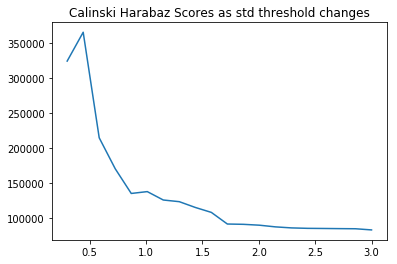

In [17]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [18]:
#empirical best threshold .75 stdev
newresults, labels = remove_outliers(results, cl,.5)

In [16]:
X=newresults
range_n_clusters = [15]
if len(newresults) <20000:
    silhouette_plotter(X, range_n_clusters)

(-15, 10)

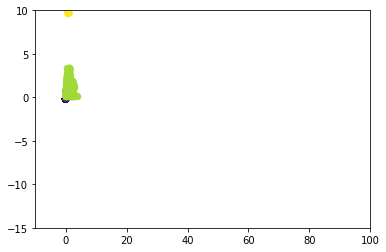

In [19]:

plt.scatter(newresults[:,0],newresults[:,1],c=labels)
plt.xlim(-10,100)
plt.ylim(-15,10)

(-15, 10)

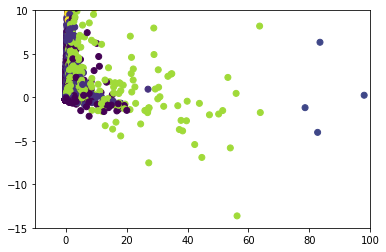

In [20]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
plt.xlim(-10,100)
plt.ylim(-15,10)

In [21]:
#recluster after changes
cl = KMeans(15).fit(results)
newcl = KMeans(15).fit(newresults)

In [22]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [21]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

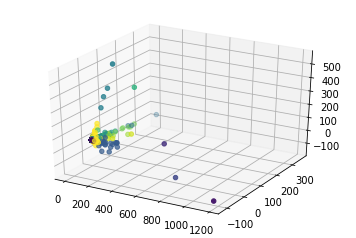

In [23]:

# plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

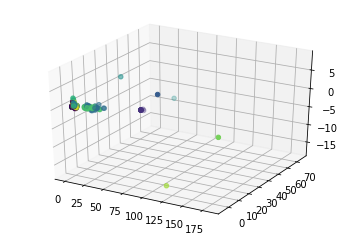

In [24]:
# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)
# ax.set_xlim3d(-1,1)
# ax.set_ylim3d(-3,3)
# ax.view_init(elev=-0, azim=90)
# for ii in range(10,360,10):
#     ax.view_init(elev=10, azim=ii)
#     fig.savefig("movie/movie{}.png".format(ii))

In [28]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = scale.inverse_transform(pca.inverse_transform(c))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [29]:
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes

In [30]:
df_summary.sort_values('cluster_size', axis=0)

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_incoming_txns,monthly_eth_sent,monthly_usd_sent,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,num_tokens_used,eth_balance,cluster_size
1,1.539893e+06,4.642263e+06,3.403855e+07,22.104492,2.047549e+10,1.329670e+04,3.440410e+07,7.411063,2.071501e+10,4.462266e+03,...,290141.437500,2.127410e+06,1.279718e+09,2.150257e+06,1.294688e+09,3.271632e-10,6.272433e-09,519.000000,299076.571854,1
2,1.252250e+06,1.084444e+06,1.273841e+08,101.724147,8.922014e+09,7.124787e+03,5.432072e+07,50.090846,3.833821e+08,3.535288e+02,...,27111.100000,3.184602e+06,2.230504e+08,1.358018e+06,9.584554e+06,1.000000e+00,5.780600e+04,298.000000,42551.527864,1
3,3.545690e+05,5.072230e+05,2.412924e+07,68.052308,1.413144e+10,3.985525e+04,2.528923e+07,49.858215,1.492746e+10,2.942977e+04,...,42268.583333,2.010770e+06,1.177620e+09,2.107436e+06,1.243955e+09,1.543694e-10,4.133017e-09,203.000000,50050.301873,1
9,5.488707e+06,2.354070e+05,2.569154e+07,4.680800,9.921043e+09,1.807537e+03,3.010143e+06,12.786973,2.031534e+07,8.629879e+01,...,5885.175000,6.422885e+05,2.480261e+08,7.525358e+04,5.078835e+05,1.300000e+01,1.326134e+06,503.000000,977374.381628,1
10,9.683000e+03,1.100000e+01,5.743477e+05,59.315062,4.777667e+08,4.934077e+04,1.900000e+01,1.727273,5.931440e+03,5.392218e+02,...,0.733333,3.828985e+04,3.185111e+07,1.266667e+00,3.954293e+02,3.066100e+05,1.909930e+05,243.000000,22192.283914,1
5,2.700000e+01,2.666667e+01,2.846250e+06,150552.120970,5.575624e+08,3.047375e+07,7.514507e-02,0.006380,3.413545e+01,3.499064e+00,...,0.919540,9.814657e+04,1.922629e+07,2.591209e-03,1.177084e+00,7.505019e-11,-4.333955e-10,73.000000,363533.291583,3
13,5.898067e+05,1.473667e+03,3.573216e+07,78.822946,7.777102e+09,1.590398e+04,3.132930e+06,21615.901380,5.155803e+08,4.142900e+06,...,47.650736,1.234745e+06,2.649069e+08,1.069458e+05,1.776484e+07,7.609646e-11,1.129987e-09,141.666667,127252.795299,3
6,9.009460e+06,1.202000e+03,2.750497e+06,0.301741,8.885120e+08,1.103784e+02,2.498890e+04,69.115046,1.636701e+07,4.628799e+04,...,61.754072,1.004891e+05,3.672456e+07,8.023592e+02,5.130198e+05,1.075000e+01,1.598768e+05,75.250000,5849.660688,4
12,1.211765e+01,1.909706e+03,2.535355e+05,4412.034769,1.057822e+08,1.876369e+06,1.397563e+06,4791.553150,2.702698e+08,1.989171e+06,...,115.728344,2.613033e+04,1.107223e+07,8.570851e+04,2.619375e+07,5.069856e-11,1.668461e-10,96.000000,885872.230034,17
4,3.047885e+05,3.178940e+05,6.451343e+06,239.693155,1.829009e+09,9.200570e+04,6.687053e+06,3082.778325,1.897147e+09,1.002120e+06,...,24377.784224,3.737469e+05,1.378667e+08,3.924380e+05,1.448697e+08,7.000000e-01,9.369900e+03,143.000000,27125.720805,20


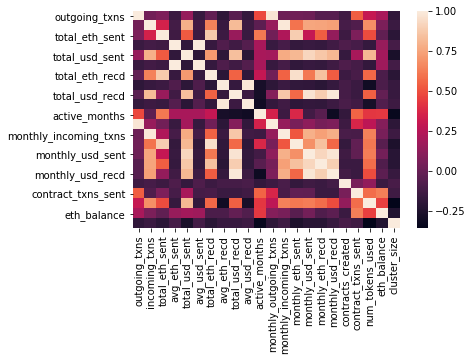

In [31]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [32]:
arr = df_summary.values

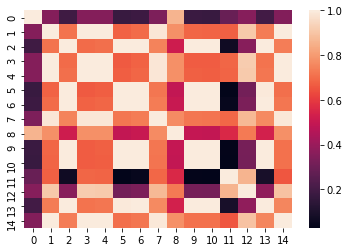

In [33]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

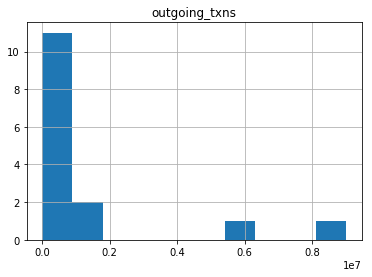

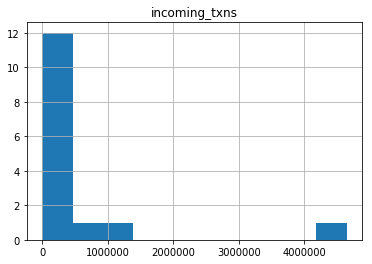

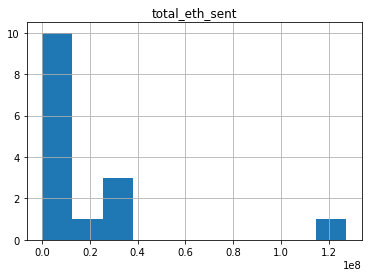

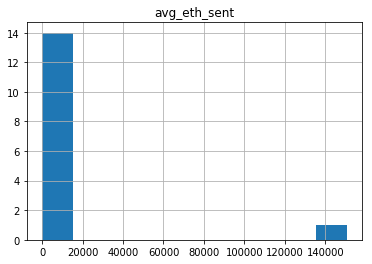

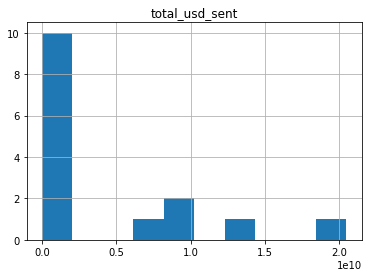

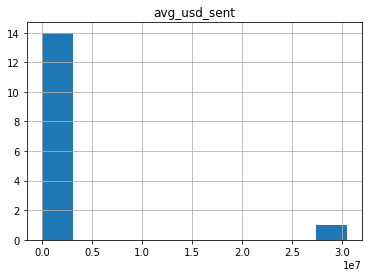

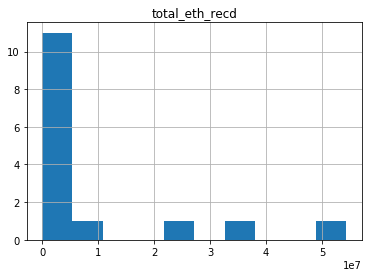

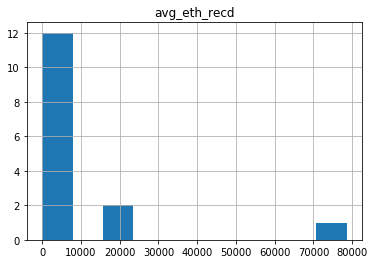

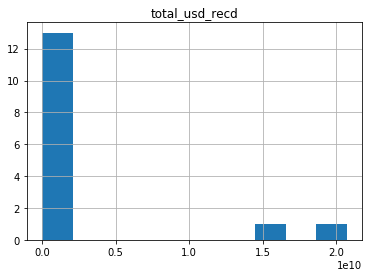

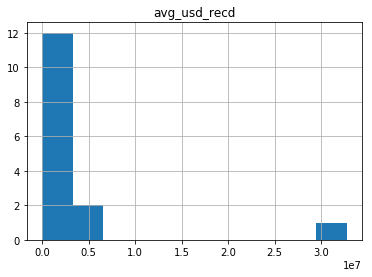

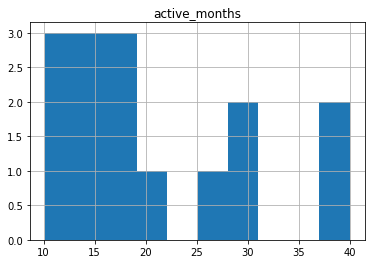

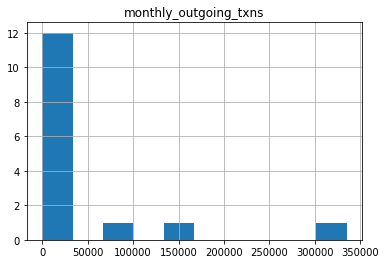

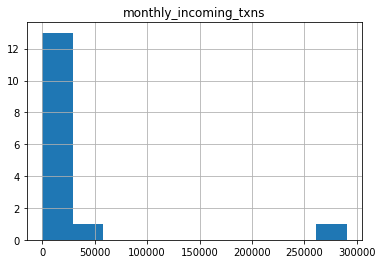

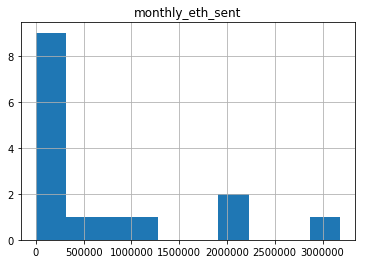

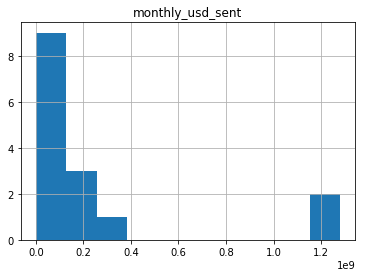

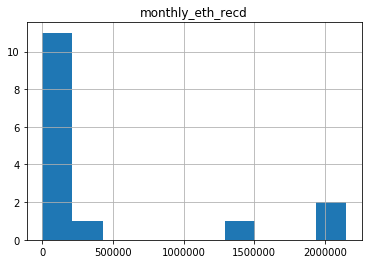

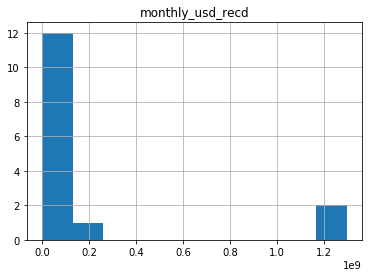

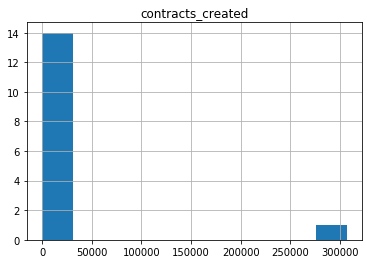

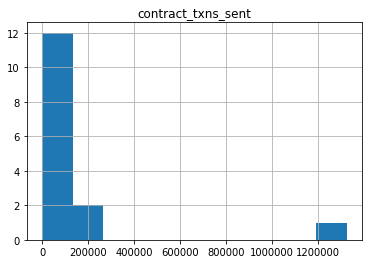

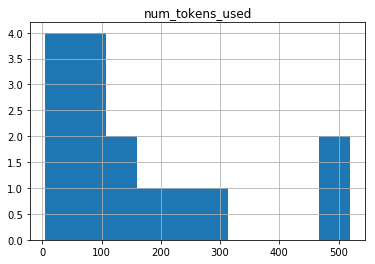

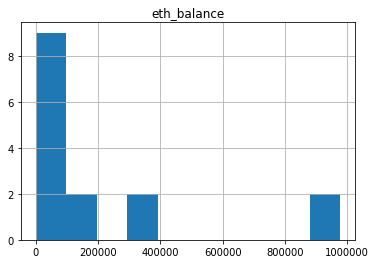

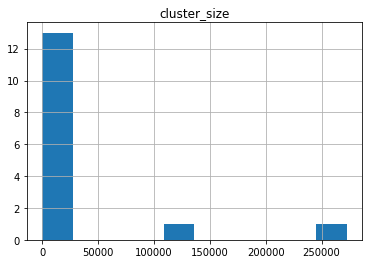

In [34]:
for col in df_summary.columns:
    df_summary[col].hist()
    plt.title(col)
    plt.show()

In [35]:
p = PCA(n_components=3)

In [36]:
vectors = p.fit_transform(arr)

In [37]:
z = np.zeros(15)
xs = vectors[:,0]
ys = vectors[:,1]
zs = vectors[:,2]

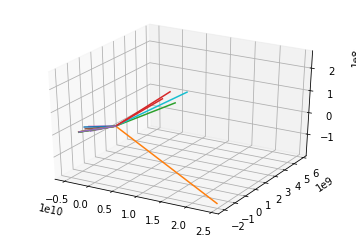

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for x,y,z in zip(xs,ys,zs):
    ax.plot([0,x], [0,y],[0,z])